# Ford GoBike Exploration


### By Sarida Tangsakul

### Investigation Overview

I want to find the connection between characteristic of main customers (i.e. age, gender, user type, and location) and their behaviour of bike usage. The behaviors are included when and where they start a trip, and how long of duration trip.


### Dataset Overview

The data consisted of users details of approximately 1.3 millions rides during October 2018 - April 2019. Due to chosen time periods, I can explore the recent 7 months dataset as well as how the weather could affect customer usages. The dataset has been cleaned and contained 16 features which included customers demographic and their trips. 

*Note*: 
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
- start_city: The city where bike station is located (San Francisco or Other - "Other" = East Bay or San Jose) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
df = pd.read_csv('ford_gobike_clean.csv')

In [3]:
df.head()

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_gender,bike_share_for_all_trip,duration_minute,day_of_week,month,hour_of_day,user_age,user_age_group,start_town
0,50305,2019-04-30 22:33:55.155,2019-05-01 12:32:20.4540,Myrtle St at Polk St,Union Square (Powell St at Post St),2749,Subscriber,Female,No,838.416667,Tuesday,4,22,30.0,age 28-37,San Francisco
1,53725,2019-04-30 20:43:41.632,2019-05-01 11:39:06.9170,Berkeley Civic Center,Ashby BART Station,2608,Customer,NaN,No,895.416667,Tuesday,4,20,NaN,NaN,San Francisco
2,78072,2019-04-30 10:32:46.489,2019-05-01 08:13:58.9750,5th St at Brannan St,5th St at Brannan St,258,Subscriber,Male,No,1301.200000,Tuesday,4,10,26.0,age 18-27,San Francisco
3,78969,2019-04-30 10:00:51.550,2019-05-01 07:57:01.2620,San Francisco Caltrain Station 2 (Townsend St...,Division St at Potrero Ave,1974,Subscriber,Male,No,1316.150000,Tuesday,4,10,47.0,age 38-47,San Francisco
4,1128,2019-04-30 23:59:04.739,2019-05-01 00:17:53.0910,19th St at Florida St,Powell St BART Station (Market St at 5th St),877,Subscriber,Male,No,18.800000,Tuesday,4,23,46.0,age 38-47,Other


In [4]:
df.start_time = pd.to_datetime(df.start_time)

In [29]:
## Month in order
month_classes = [10, 11, 12, 1, 2, 3, 4]
monthclasses= pd.api.types.CategoricalDtype(ordered = True, categories = month_classes)
df.month = df.month.astype(monthclasses);

In [6]:
##  Day of week in order
day_classes = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayclasses = pd.api.types.CategoricalDtype(ordered = True, categories = day_classes)
df.day_of_week = df.day_of_week.astype(dayclasses);

In [7]:
## Age in order
age_classes = ['age 18-27', 'age 28-37', 'age 38-47', 'age 48-57', 'above 55', 'NaN']
ageclasses = pd.api.types.CategoricalDtype(ordered = True, categories = age_classes)
df.user_age_group = df.user_age_group.astype(ageclasses);

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337860 entries, 0 to 1337859
Data columns (total 16 columns):
duration_sec               1337860 non-null int64
start_time                 1337860 non-null datetime64[ns]
end_time                   1337860 non-null object
start_station_name         1335098 non-null object
end_station_name           1335098 non-null object
bike_id                    1337860 non-null int64
user_type                  1337860 non-null object
member_gender              1278207 non-null object
bike_share_for_all_trip    1337860 non-null object
duration_minute            1337860 non-null float64
day_of_week                1337860 non-null category
month                      1337860 non-null category
hour_of_day                1337860 non-null int64
user_age                   1278190 non-null float64
user_age_group             1234936 non-null category
start_town                 1337860 non-null object
dtypes: category(3), datetime64[ns](1), float64(2), int64(

## User Characteristics and User Behaviours

### 1. User type (Subscriber Vs Customer)

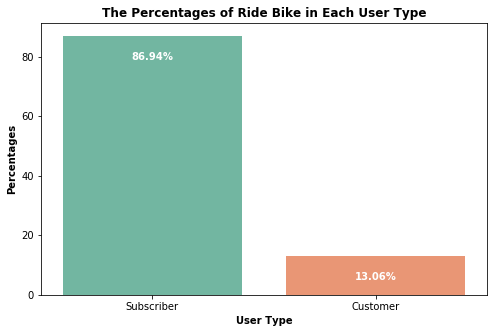

In [39]:
# User type percentages
count_type = df.user_type.value_counts() / df.user_type.count() *100

plt.figure(figsize = [8, 5])

#sb.barplot(data = count_type, x= 'index', y = 'percentages', palette = 'Set2')
sb.barplot(count_type.index.values, count_type, palette = 'Set2')
plt.title('The Percentages of Ride Bike in Each User Type', fontweight ='bold')
plt.xlabel('User Type', fontweight ='bold')
plt.ylabel('Percentages', fontweight ='bold')

# add annotations
n_points = df.shape[0]
locs, labels = plt.xticks() 

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = count_type[label.get_text()]
    pct_string = '{:0.2f}%'.format(count)

    # print the annotation just below the top of the bar
    plt.text(loc, count -8, pct_string, ha = 'center', color = 'w', fontweight ='bold');

#### 1.1 Daily trend

- Total line: The trend of bike rides during November2018 - December2018 were decreased maybe because of weather. In addtion, there is weekly trend fluctuated; for example,  it is lower than 2,000 in the end of November. After January the number of ride bikes gradually increase, and the highest value is more than 10,000. However, a graph is suddenly dropped in mid-april. The causation maybe Ford GoBike suspended electric-assist bike service after braking issues during that time (ref: shorturl.at/suwR2).
- Most users are subscriber so it obviously affects the trend of total line. 
- Customer line is less fluctuated compared to the subscriber and total line (Be less affected by the weather or the company issues).

In [9]:
cust = df.query('user_type == "Customer"')
sub = df.query('user_type == "Subscriber"')

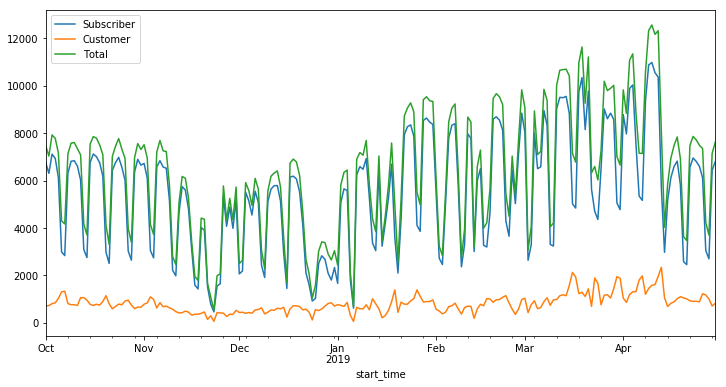

In [10]:
plt.figure(figsize = [12, 8])

sub.groupby(sub.start_time.dt.to_period('D')).agg('count')['bike_id'].plot(kind = 'line', figsize = [12, 6], label = 'Subscriber')
cust.groupby(cust.start_time.dt.to_period('D')).agg('count')['bike_id'].plot(kind = 'line', figsize = [12, 6], label = 'Customer')
df.groupby(df.start_time.dt.to_period('D')).agg('count')['bike_id'].plot(kind = 'line', figsize = [12, 6], label = 'Total')
plt.legend();

#### 1.2 Day of week and Hour of day

- **Hour of day & Day of week**: There are two patterns in the graph: a weekday and a weekend pattern. The peak of weekday lines are around 8am and 5pm. Compare to the weekday lines, the weekend lines are significantly lower and they look like a bell curve (popular time is around 10am-7pm). 

In [11]:
# Day of week and Hour of day
day_hour_counts = df.groupby(['day_of_week', 'hour_of_day']).size()
day_hour_counts = day_hour_counts.reset_index(name = 'count')

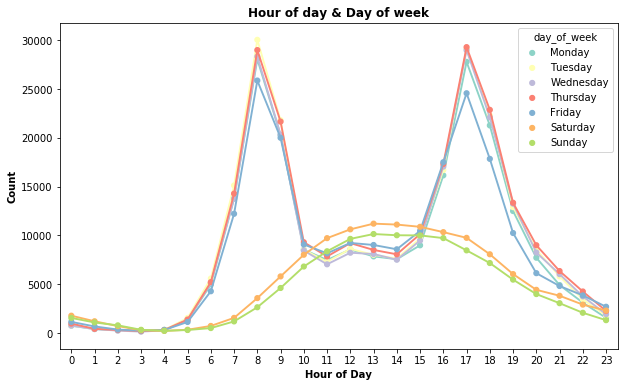

In [12]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='hour_of_day', y='count', hue= 'day_of_week', scale=.7, data= day_hour_counts, palette = 'Set3')
plt.title('Hour of day & Day of week', fontweight ='bold')
plt.xlabel('Hour of Day', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- **Does subscriber and customer have different time usage?**: 

    Subscriber lines has peaks at 8am and 5pm, while customer line steadily for all day.

In [13]:
# User type and hour of day
user_hour_counts  = df.groupby(['hour_of_day', 'user_type']).size()
user_hour_counts  =user_hour_counts.reset_index(name = 'count')

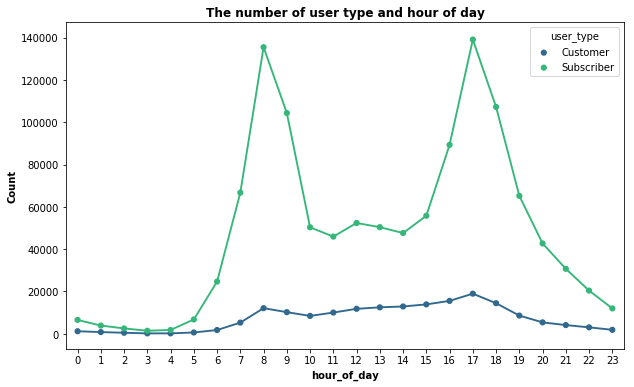

In [14]:
plt.figure(figsize = [10, 6])

ax = sb.pointplot(x='hour_of_day', y='count', hue='user_type', scale=.7, data= user_hour_counts, palette = 'viridis')
plt.title('The number of user type and hour of day', fontweight ='bold')
plt.xlabel('hour_of_day', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- **User type and day ofweek**: Subscriber demand of bicycles is high during Monday - Friday (Weekday) and is largely decreased on Saturday and Sunday (Weekend). On the other hand, customer's usage is almost the same number in each day.

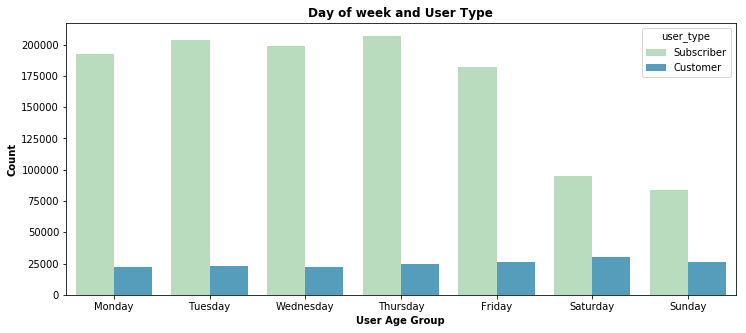

In [15]:
plt.figure(figsize = [12, 5])

sb.countplot(data =df, x= 'day_of_week', hue = 'user_type',  palette = 'GnBu')
plt.title('Day of week and User Type', fontweight ='bold')
plt.xlabel('User Age Group', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

#### 1.3 Duration minutes

- The duration graph is a right skewed distribution. Most users spend times around 10 minutes per trip. It is possible that they used it to travel a near place. 

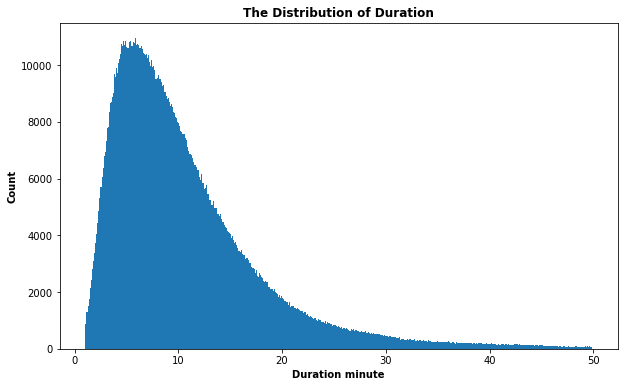

In [16]:
plt.figure(figsize = [10, 6])

bin_edges = np.arange(1, 50, 0.1)
plt.hist( data = df, x = 'duration_minute', bins = bin_edges)
plt.title('The Distribution of Duration', fontweight ='bold')
plt.xlabel('Duration minute', fontweight ='bold')
plt.ylabel('Count', fontweight ='bold');

- **Duration minute distribution in each user type**:

    - Surprisingly, customers tend to spend more time using a bike in average than subscribers around 10-15 minutes. 
    - Customers have larger distributions than subscribers especially on the weekends.

In [17]:
df.groupby(['user_type', 'day_of_week']).duration_minute.describe()

count       mean        std       min        25%  \
user_type  day_of_week                                                        
Customer   Monday        21875.0  23.733018  60.974514  1.033333   8.600000   
           Tuesday       22801.0  22.598995  57.317983  1.016667   8.400000   
           Wednesday     22173.0  22.316019  59.234417  1.016667   8.316667   
           Thursday      24764.0  23.504389  63.900323  1.016667   8.350000   
           Friday        26535.0  24.214422  63.099160  1.016667   8.750000   
           Saturday      30449.0  33.029975  80.219095  1.016667  10.500000   
           Sunday        26073.0  32.385842  74.388743  1.033333  10.450000   
Subscriber Monday       192648.0  10.667838  19.823536  1.016667   5.383333   
           Tuesday      203897.0  10.562252  19.319823  1.016667   5.366667   
           Wednesday    198909.0  10.676868  20.029763  1.016667   5.383333   
           Thursday     206940.0  10.633541  17.924820  1.016667   5.400000   
           Friday       182059.0  10.893678  20.082293  1.016667   5.433333   
           Saturday      95133.0  12.587514  27.529035  1.016667   5.383333   
           Sunday        83604.0  12.450546  27.434550  1.016667   5.233333   

                              50%        75%          max  
user_type  day_of_week                                     
Customer   Monday       13.500000  21.683333  1393.283333  
           Tuesday      12.966667  20.650000  1419.583333  
           Wednesday    12.900000  20.183333  1419.800000  
           Thursday     12.933333  20.433333  1433.050000  
           Friday       13.683333  22.033333  1429.800000  
           Saturday     17.766667  29.100000  1421.633333  
           Sunday       17.883333  29.150000  1408.266667  
Subscriber Monday        8.400000  12.750000  1415.133333  
           Tuesday       8.400000  12.683333  1436.750000  
           Wednesday     8.450000  12.766667  1424.066667  
           Thursday      8.450000  12.850000  1347.083333  
           Friday        8.516667  12.916667  1356.833333  
           Saturday      8.750000  14.216667  1433.983333  
           Sunday        8.533333  13.950000  1435.233333

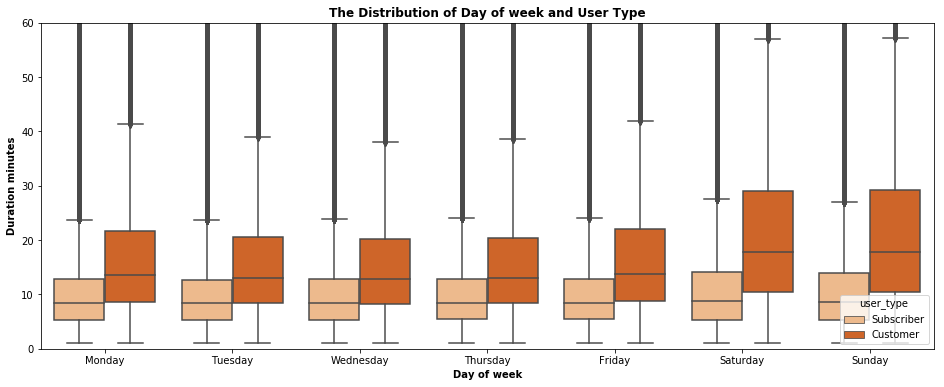

In [18]:
plt.figure(figsize = [16, 6])
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'user_type', palette = 'Oranges')
plt.title('The Distribution of Day of week and User Type', fontweight ='bold')
plt.xlabel('Day of week', fontweight ='bold')
plt.ylabel('Duration minutes', fontweight ='bold')
plt.ylim(0,60);

#### 1.4 Popular start station & end station
- **Subscriber**: The first and the second start and end station of subscriber are the same names which are San Francisco Caltrain Station 2 (Townsend St at 4th St), and Market St at 10th. Top10 start and end stations are near San Francisco train station or located on Market street.


- **Customer**: The first and the second start and end station of customer are the same which are San Francisco Ferry Building (Harry Bridges Plaza), and The Embarcadero at Sansome St. Customer tend to travel around the Bay area, downtown, and park. 

In [19]:
# The most popular start station
start_cust = cust.start_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)
start_sub = sub.start_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

In [20]:
# The most popular end station
end_sub = sub.end_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)
end_cust = cust.end_station_name.value_counts().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

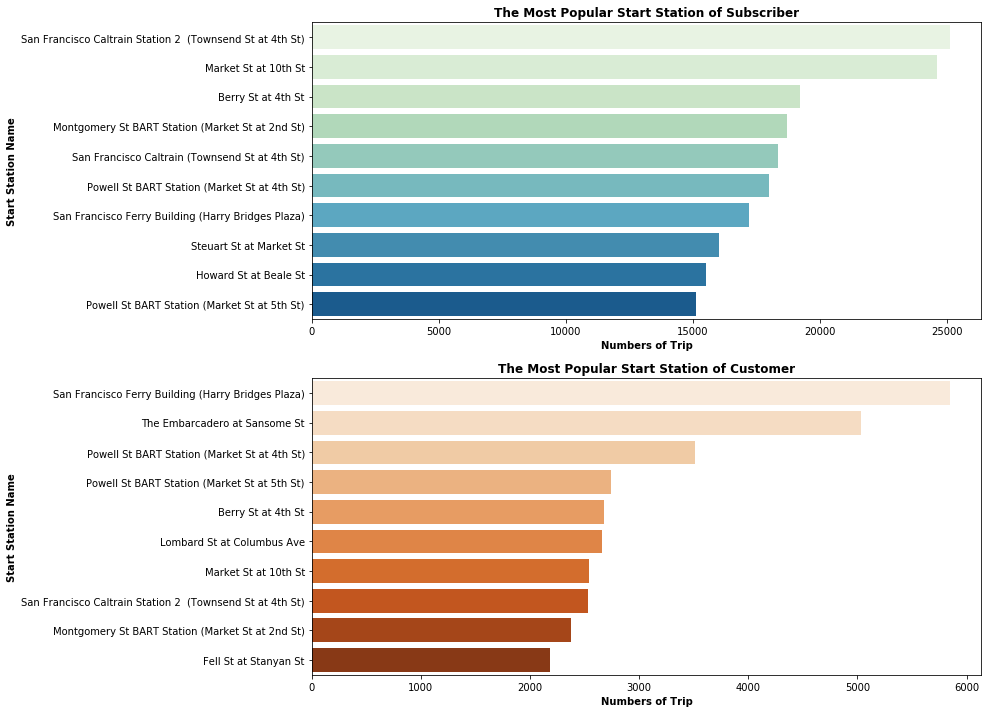

In [57]:
fig, ax = plt.subplots(nrows=2, figsize = [12,12])

sb.barplot(data = start_sub, x= 'counts', y = 'index', palette = 'GnBu', ax = ax[0])
ax[0].set_title('The Most Popular Start Station of Subscriber', fontweight ='bold')
ax[0].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[0].set_ylabel('Start Station Name', fontweight ='bold')

sb.barplot(data = start_cust, x= 'counts', y = 'index', palette = 'Oranges', ax = ax[1])
ax[1].set_title('The Most Popular Start Station of Customer', fontweight ='bold')
ax[1].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[1].set_ylabel('Start Station Name', fontweight ='bold');

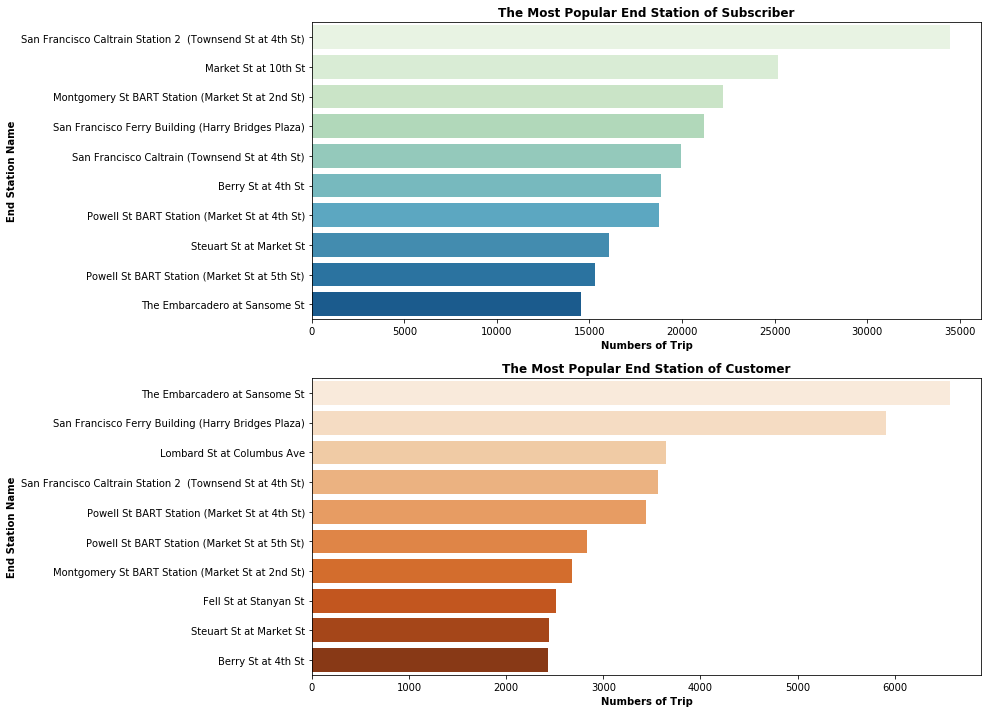

In [56]:
fig, ax = plt.subplots(nrows=2, figsize = [12,12])

sb.barplot(data = end_sub, x= 'counts', y = 'index', palette = 'GnBu', ax = ax[0])
ax[0].set_title('The Most Popular End Station of Subscriber', fontweight ='bold')
ax[0].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[0].set_ylabel('End Station Name', fontweight ='bold')

sb.barplot(data = end_cust, x= 'counts', y = 'index', palette = 'Oranges', ax = ax[1])
ax[1].set_title('The Most Popular End Station of Customer', fontweight ='bold')
ax[1].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[1].set_ylabel('End Station Name', fontweight ='bold');

#### 1.5 Popular Route

- The popular route of subscriber is to travel between the train station and in town. However, casual customer tend to choose the route around the Bay area and park. Especially the first popular route is San Francisco Ferry Building (Harry Bridges Plaza) to The Embarcadero at Sansome St which are in the recommendation route by the Ford Gobike website. It is a route that user can enjoy the view of the Bay and the largest farmer's market in town. 

In [22]:
# The most popular route
route_sub = sub.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)
route_cust = cust.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

In [23]:
route_sub['route'] = route_sub[['start_station_name', 'end_station_name']].apply(lambda x: '->'.join(x), axis=1) 
route_cust['route'] = route_cust[['start_station_name', 'end_station_name']].apply(lambda x: '->'.join(x), axis=1) 

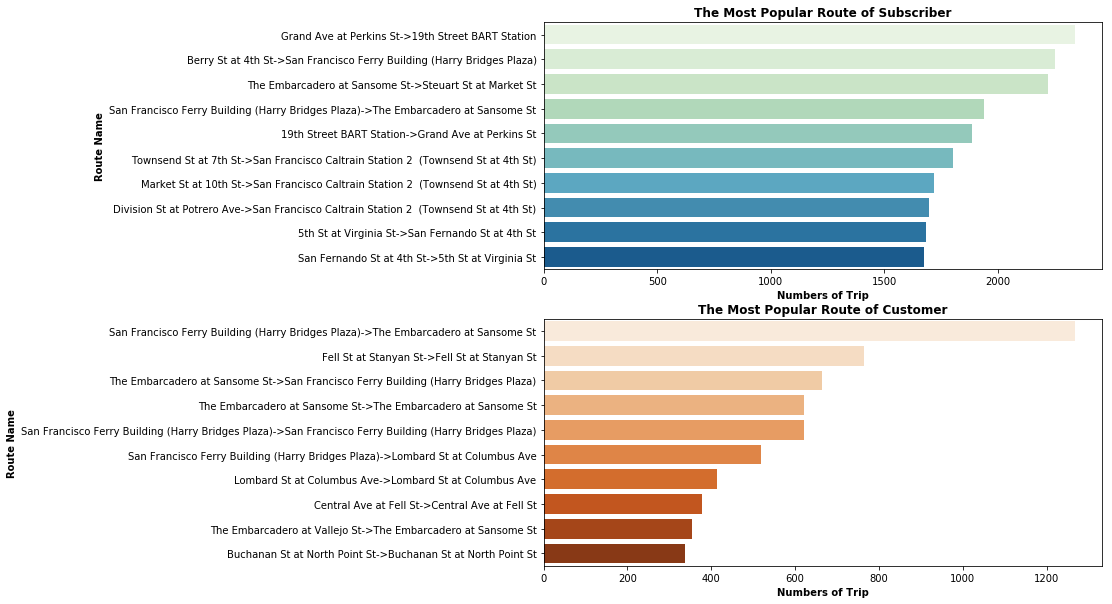

In [24]:
fig, ax = plt.subplots(nrows=2, figsize = [10,10])

sb.barplot(data = route_sub, x= 'counts', y = 'route', palette = 'GnBu', ax = ax[0])
ax[0].set_title('The Most Popular Route of Subscriber', fontweight ='bold')
ax[0].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[0].set_ylabel('Route Name', fontweight ='bold')

sb.barplot(data = route_cust, x= 'counts', y = 'route', palette = 'Oranges', ax = ax[1])
ax[1].set_title('The Most Popular Route of Customer', fontweight ='bold')
ax[1].set_xlabel('Numbers of Trip', fontweight ='bold')
ax[1].set_ylabel('Route Name', fontweight ='bold');

### 2. Other Behaviours: Member Gender, Age Group, ans Start Town

#### 2.1 Member Gender

- It shows that the peak hour of rides between male and female for each days are similar (except male has a lager number of usage than female).
- We can divide the peak time into 2 patterns : weekday is peak at 8am and 5pm, and weekend is around afternoon.

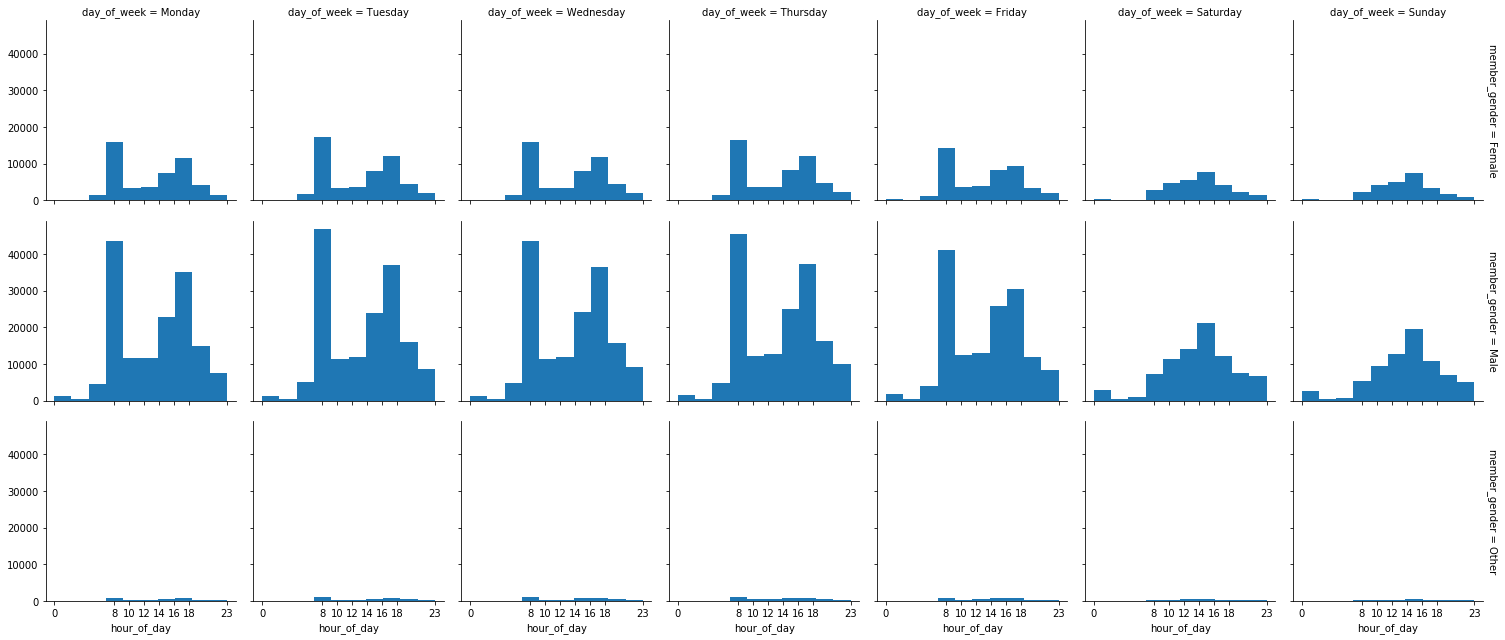

In [58]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col= "day_of_week", row="member_gender", margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color)

#### 2.3 User age group

- All user age group have the same peak time for each day.
- If we divided days into weekday and weekend, we can see that all age group have the same amout of rides in each hour of day. Or we could says that bike rides is kind of a daily routine transportation of whole age group users.

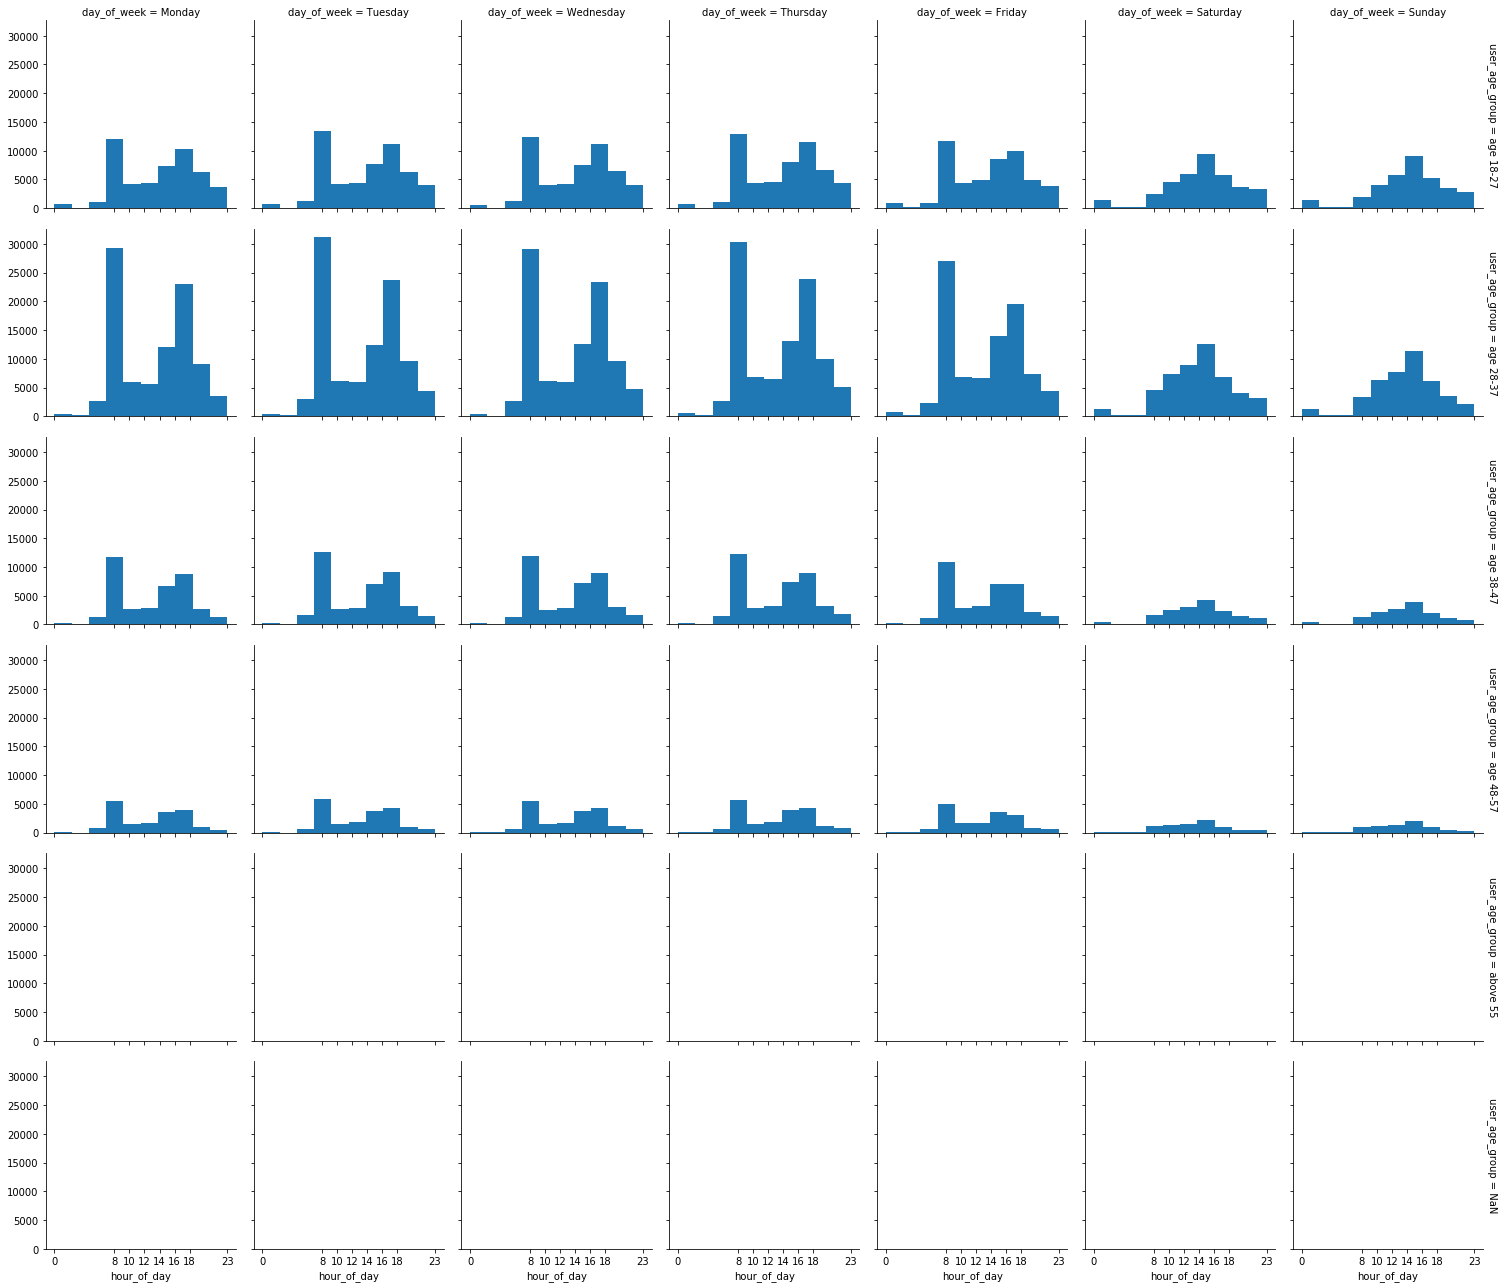

In [26]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col='day_of_week' , row= 'user_age_group',
                margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color);

#### 2.4 Start town (we assume by the start station location)

- Besides San Francisco has a larger number of usage than other cities, both groups have the same hour of day pattern for whole week.

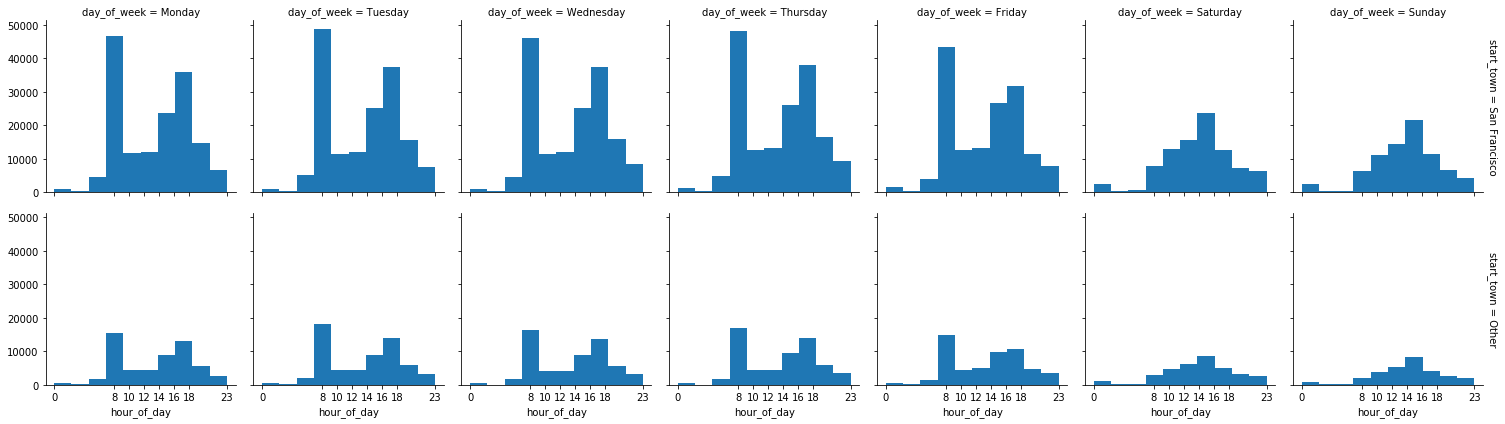

In [27]:
base_color = sb.color_palette()[0]
g = sb.FacetGrid(df, col=  'day_of_week', row= 'start_town', margin_titles = True)
g.set(xticks = [0, 8, 10, 12, 14, 16, 18, 23])
g = g.map(plt.hist, 'hour_of_day', color= base_color);

#### 2.5 The duration distribution 

- In summary, we cannot find the different of usage durations by using customer characteristics like member gender, user age group, and start town. All of them have the similar patterns of duration distributions; for example, all median of duration minutes is around 10 minutes.

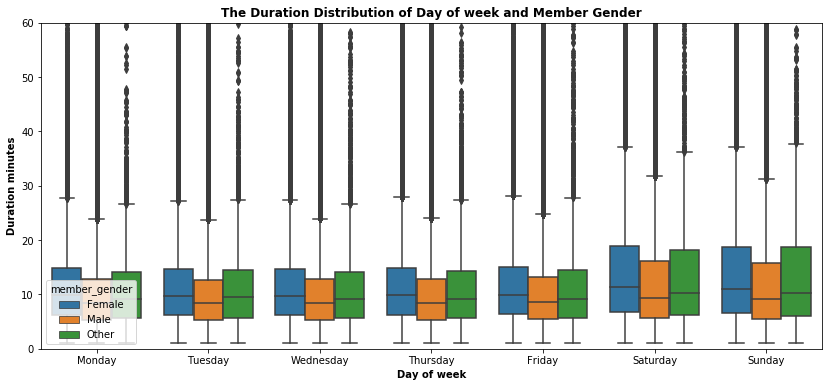

In [46]:
plt.figure(figsize = [14, 6])

sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'member_gender', palette = 'tab10')
plt.title('The Duration Distribution of Day of week and Member Gender', fontweight ='bold')
plt.xlabel('Day of week', fontweight ='bold')
plt.ylabel('Duration minutes', fontweight ='bold')
plt.ylim(0,60);

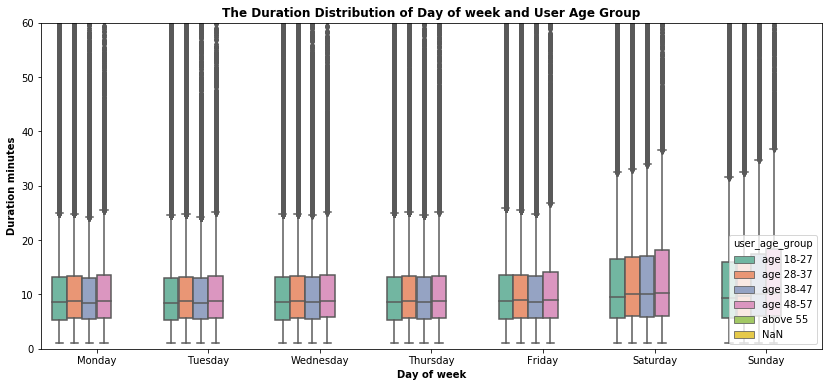

In [48]:
plt.figure(figsize = [14, 6])
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'user_age_group', palette = 'Set2')
plt.title('The Duration Distribution of Day of week and User Age Group', fontweight ='bold')
plt.xlabel('Day of week', fontweight ='bold')
plt.ylabel('Duration minutes', fontweight ='bold')
plt.ylim(0,60);

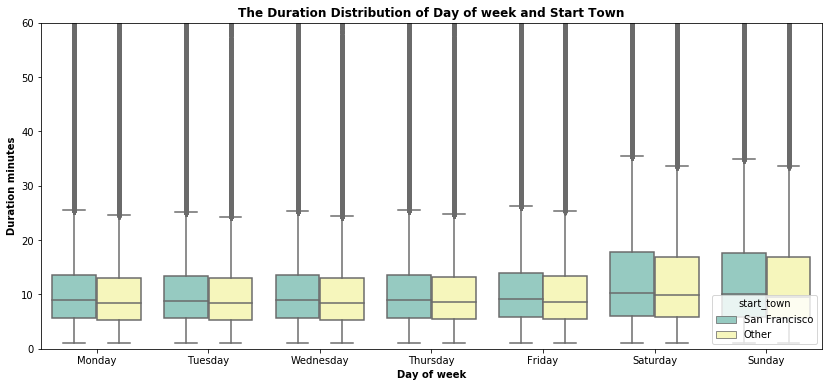

In [49]:
plt.figure(figsize = [14, 6])
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_minute', hue = 'start_town', palette = 'Set3')
plt.title('The Duration Distribution of Day of week and Start Town', fontweight ='bold')
plt.xlabel('Day of week', fontweight ='bold')
plt.ylabel('Duration minutes', fontweight ='bold')
plt.ylim(0,60);

### Conclusion

Besides user types, other characteristics can not differentiate the unqiue of customer behaviors (They have the exact same usage pattern). Most user type is subscriber who tend to use the bikeshare for daily routine transportation so the most popular bike stations are around the public transportation (i.e trains, bus) or near workplace. On the other hand, casual customer likely to be a tourist who spend a longer duration per trip and they use bikeshare around the tourist attractions (i.e the Bay, farmer markets, and the park). In summary, Ford GoBike could use these characteristics and behaviours to launch the marketing offers that suit the target customer expectation, as well as, manage the number of bikes to meet user demands for the whole day.